# Análise de Sentimento - Auto Atenção Completa

Nome: Thomás Portugal

Neste colab iremos melhorar o modelo anterior de análise de sentimento usando a Auto Atenção completa: embedding posicional, projeção linear do k,q,v e saída, Atenção multi-cabeça, Scaled Dot-product, Layer Normalization, Conexões residuais, Camada de feed forward (2-layer MLP).
Usaremos todo dataset do IMDB (25k treino, 25k teste).


In [ ]:
import numpy as np 
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from math import ceil
from matplotlib import pyplot as plt
from time import time
from tqdm import tqdm_notebook
import gc
gc.collect()
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu" 
print(dev)
device = torch.device(dev)

cuda:0


# Preparando Dados

Primeiro, fazemos download do dataset:

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

--2020-07-02 14:05:17--  http://files.fast.ai/data/aclImdb.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145982645 (139M) [application/x-gtar-compressed]
Saving to: ‘aclImdb.tgz’

aclImdb.tgz         100%[===================>] 139.22M  13.7MB/s    in 12s     

2020-07-02 14:05:29 (11.9 MB/s) - ‘aclImdb.tgz’ saved [145982645/145982645]



## Carregando o dataset

In [ ]:
import os


def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)


print(len(x_train), 'amostras de treino.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras teste:')
for x, y in zip(x_test[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras teste:')
for x, y in zip(x_test[-3:], y_test[-3:]):
    print(y, x[:100])

25000 amostras de treino.
25000 amostras de teste.
3 primeiras amostras treino:
True I would love to comment on this film. Alas , my search has always endeth in vain. If any good citize
True George Cukor directs this high quality story of suspense in the theatrical world with his usual sens
True Peter Sollett has created an endearing portrait about real people living in poverty in the Lower Eas
3 últimas amostras treino:
False Anyone who's watched a few Lifetime Movie Network movies knows that plot credibility is the first th
False You know you're in trouble when John Cassavetes is operating at half-speed instead of full-throttle 
False I have no clue as to what this was shot on but you can definitely tell that they had no budget. Bad 
3 primeiras amostras teste:
True I just thought I would add another observation, here. While there are a couple of visual sub-referen
True A wonderful family movie & a beautiful horse movie. 75+ %entertainment. Casey, Buddy, Kelly Marsh ar
True I think t

# Fazer download do word embedding

Primeiro fazemos download dos word embeddings. Lista dos modelos disponíveis: https://github.com/RaRe-Technologies/gensim-data#models

In [ ]:
import gensim.downloader as api

word2vec_model = api.load("glove-wiki-gigaword-300")
print(word2vec_model.vectors.shape)

[==============================================----] 92.5% 348.1/376.1MB downloaded(400000, 300)


# Criando Vocabulário a partir do word embedding

In [ ]:
import itertools

vocab = {word: index for index, word in enumerate(word2vec_model.index2word)}

# Adicionar pad token
vocab['[PAD]'] = len(vocab)
pad_vector = np.zeros((1, word2vec_model.vectors.shape[1]))
embeddings = np.concatenate((word2vec_model.vectors, pad_vector), axis=0)
embeddings = torch.tensor(embeddings)

print('Número de palavras no vocabulário:', len(vocab))
print(f'20 tokens mais frequentes: {list(itertools.islice(vocab.keys(), 20))}')

Número de palavras no vocabulário: 400001
20 tokens mais frequentes: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']


# Tokenizando o dataset e convertendo para índices

In [ ]:
import collections
import itertools


def tokenize(text):
    for char in ['"', '\'', '.', ',', ':', '-', '?', '!']:
        text = text.replace(char, ' ')
    return text.lower().split()


def tokens_to_ids(tokens, vocab):
    return [vocab[token] for token in tokens if token in vocab]


def tokens_to_ids_batch(texts, vocab):
    return [tokens_to_ids(tokenize(text), vocab) for text in texts]
        

x_train_indices = tokens_to_ids_batch(x_train, vocab)
x_test_indices = tokens_to_ids_batch(x_test, vocab)

print('Primeiro exemplo:')
print(x_train[0])
print(x_train_indices[0])
print(y_train[0])

Primeiro exemplo:
I would love to comment on this film. Alas , my search has always endeth in vain. If any good citizen could help a desperate inhabitant of this ailing planet and restore his confidence in humanity by offering the whereabouts of either a UK VHS or loan him a DVD copy of the VHS; he would, without reservation, be eternally grateful..... <br /><br />Blake wrote "The road to excess is the path to wisdom", one hopes my weary road of excess will offer the path to fruition .... If not, I will have to replay the excellent Mr Russel's Gothic in the knowledge that those who have seen Haunted Summer (for better or for worse) have enriched their viewing pleasure of the events of July 1816 whilst I, a fellow member of this melodious plot, rests his lonely case in solitude ...
[41, 54, 835, 4, 1320, 13, 37, 319, 19578, 192, 1468, 31, 690, 6, 13276, 83, 130, 219, 3941, 94, 275, 7, 5317, 44918, 3, 37, 7550, 4090, 5, 3614, 26, 1513, 6, 5645, 21, 2111, 0, 10631, 3, 900, 7, 2046, 20237,

# Definindo a Rede Neural

## Transformando word ids em batches

In [ ]:
def truncate_and_pad(batch_word_ids, pad_token_id, seq_length=64):

    # Truncate.
    batch_word_ids = [word_ids[:seq_length] for word_ids in batch_word_ids]

    # Create mask.
    mask = [
        [1] * len(word_ids) + [0] * (seq_length - len(word_ids))
        for word_ids in  batch_word_ids]

    # Pad.
    batch_word_ids = [
        word_ids + [pad_token_id] * (seq_length - len(word_ids))
        for word_ids in batch_word_ids]

    return batch_word_ids, mask

texts = ['we like pizza', 'he does not like apples']
batch_word_ids = tokens_to_ids_batch(texts, vocab)
print(batch_word_ids)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids,
                 pad_token_id=vocab['[PAD]'],
                 seq_length=8)
text = x_train


batch = np.array(batch)
mask = np.array(mask)
print('batch', batch)
print('mask', mask)
print('batch.shape:', batch.shape)
print('mask.shape:', mask.shape)

[[53, 117, 9388], [18, 260, 36, 117, 13134]]
batch [[    53    117   9388 400000 400000 400000 400000 400000]
 [    18    260     36    117  13134 400000 400000 400000]]
mask [[1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0]]
batch.shape: (2, 8)
mask.shape: (2, 8)


In [ ]:
x_train[0]

texts = x_train[0:2]
batch_word_ids = tokens_to_ids_batch(texts, vocab)
print(batch_word_ids)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids,
                 pad_token_id=vocab['[PAD]'],
                 seq_length=1000)
batch = np.array(batch)
mask = np.array(mask)
print('batch', batch)
print('mask', mask)
print('batch.shape:', batch.shape)
print('mask.shape:', mask.shape)


[[41, 54, 835, 4, 1320, 13, 37, 319, 19578, 192, 1468, 31, 690, 6, 13276, 83, 130, 219, 3941, 94, 275, 7, 5317, 44918, 3, 37, 7550, 4090, 5, 3614, 26, 1513, 6, 5645, 21, 2111, 0, 10631, 3, 900, 7, 2046, 20237, 46, 2264, 103, 7, 4180, 4522, 3, 0, 18, 54, 296, 9454, 30, 41128, 8908, 836, 0, 586, 4, 6572, 14, 0, 2818, 4, 7151, 48, 1355, 192, 11936, 586, 3, 6572, 43, 901, 0, 2818, 4, 27866, 83, 36, 41, 43, 33, 4, 11962, 0, 4345, 6380, 34369, 1534, 10006, 6, 0, 2489, 12, 155, 38, 33, 541, 12496, 740, 439, 46, 10, 33, 10446, 44, 8109, 7794, 3, 0, 958, 3, 375, 18384, 7023, 41, 7, 1773, 393, 3, 37, 69747, 2219, 13785, 26, 10678, 305, 6, 25701], [649, 87019, 14719, 37, 152, 1506, 523, 3, 17495, 6, 0, 8601, 85, 17, 26, 3518, 3541, 34, 1001, 3255, 5184, 42182, 1534, 883, 42, 1770, 103, 29, 3991, 149, 2577, 60, 504, 7, 306, 49157, 4039, 20, 1534, 605, 4, 4458, 26, 12496, 44788, 19, 18, 39824, 55310, 204, 659, 4341, 5, 3334, 4, 596, 2301, 6, 26, 214, 63, 32, 7, 223, 3, 4001, 167853, 5, 87019, 260, 

In [ ]:
#Separação em treino e validação.
x_val = x_train[20000:]
x_train = x_train[:20000]
y_val = y_train[20000:]
y_train = y_train[:20000]

In [ ]:
len(x_val)

5000

  # Criando Classe do Dataset


In [ ]:
class Dataset_IMDB(Dataset):
  def __init__(self,X,Y, sentence_size = 100):
    pad = vocab['[PAD]']
    batch_word_ids = tokens_to_ids_batch(X, vocab)
    self.X, self.mask = truncate_and_pad(batch_word_ids, pad, seq_length = sentence_size)
    self.X = torch.tensor(self.X, dtype = torch.long)
    self.Y = torch.tensor(Y, dtype = torch.long)
    self.mask = torch.tensor(self.mask, dtype = torch.long)
  

  def __getitem__(self,idx):
    return (self.X[idx],self.Y[idx],self.mask[idx])
  
  def __len__(self):
    return len(self.X)


In [ ]:
sentence_size = 200
embedding_dim = embeddings.size()[1]
dataset_imdb_train = Dataset_IMDB(x_train, y_train, sentence_size = sentence_size)
dataset_imdb_val = Dataset_IMDB(x_val, y_val, sentence_size = sentence_size)
dataset_imdb_test = Dataset_IMDB(x_test, y_test, sentence_size = sentence_size)

In [ ]:
dataset_imdb_val[:10][1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
batches_tst = DataLoader(dataset_imdb_val, batch_size=400, shuffle=True) #Dataloader para testar função isoladamente

Teste para avaliar o shape

In [ ]:
for batch_X, batch_Y, mask in batches_tst:
  print(batch_X.shape)
  print(batch_Y.shape)
  print(batch_X[0])
  break

torch.Size([400, 200])
torch.Size([400])
tensor([ 28291,     22,      0,   4877,     14,     48,      3,    155,   2459,
            17,      7,    561,      0,   3468,    523,     12,   1534,     56,
          4001,     73,      0,   1005,   1003,     37,     15,  22065,   1534,
          7926,   2841,     10,  23247,    105,     26,     62,      3,  23681,
             5,     26,     58,     55, 221957,    187,     18,    334,     48,
             3,     26,     76,     66,      5,     66,  13455,   3354,      0,
          2047,   2653,  71285,   1534,  31740,   7196,     15,    553,      4,
             5,     20,     52,   2380,     48,      3,      0,     76,    246,
            18,     54,    161,     10,      7,    369,     68,     73,    670,
             6,    853,  22065,   1534,   4748,     17,    369,      5,   1644,
           753,  28291,  70170,    591,    405,    103,   1439,     25,      0,
          2014,   2159,   5042,    385,     17,     26,    350,   3198,   1793,

# Função de Self Attention

In [ ]:
def SelfAttention(keys,query,values,index_pads, embedding_dim = 300):
  
  index_pads = index_pads==0 #Transformação para tensor booleano
  scores = torch.matmul(keys,query.transpose(-1,-2))
  scores = scores / torch.tensor(embedding_dim, dtype = torch.float)
  scores[index_pads] = torch.tensor(-9999, dtype = torch.float) #Atribuir score baixo para padding não afetar as probs
  probs = torch.nn.functional.softmax(scores, dim=-1)
  embeddings_output = torch.matmul(probs,values)

  return embeddings_output
  

Teste da função de Self Attention. Shapes corretos.


In [ ]:
# %%timeit

embedding_dim = 300
vocab_size = len(vocab)
num_heads = 6
embedding = torch.nn.Embedding(vocab_size,embedding_dim) 

for batch_X, batch_Y, mask in batches_tst:
  batch_X = embedding(batch_X)
  batch_size = len(batch_X)
  batch_X = batch_X.view(batch_size, sentence_size, num_heads, ceil(embedding_dim/num_heads)) #Transformação para multi-head
  print("Shape do batch antes de aplicar atenção com multi head:", tuple(batch_X.shape))
  mask = mask.expand(num_heads,batch_size,sentence_size).transpose(0,1) #Adequação para o numero de dimensões e a presença de multi-head
  k = batch_X.transpose(1,2) # Transpondo para que os cálculos de cada head sejas feita paralelamente.
  o = SelfAttention(k, k, k, mask)
  o = o.transpose(1,2).contiguous() 
  o = o.view(batch_size, sentence_size,embedding_dim) #Transformando para se obter as dimensões originais
  print("Shape do batch de saída: ", tuple(o.shape))
  break

Shape do batch antes de aplicar atenção com multi head: (400, 200, 6, 50)
Shape do batch de saída:  (400, 200, 300)


In [ ]:
class FullAttention(torch.nn.Module):
  def __init__(self,embeddings,embedding_dim = 300, sentence_size = 100, train_embedding = False, num_heads = 6):
    super().__init__()
    vocab_size = len(embeddings)
    # embeddings = embeddings.to(device)
    self.num_heads = num_heads
    self.sentence_size = sentence_size
    self.embedding_dim = embedding_dim
    self.pos = torch.arange(sentence_size).to(device)
    
    # Camada de embeddings pre treinados
    self.embedding = torch.nn.Embedding(vocab_size,embedding_dim)
    self.embedding.weight = torch.nn.Parameter(embeddings)
    
    if not train_embedding:
        self.embedding.weight.requires_grad = False
    
    # Camada com embeddings posicionais
    self.positional = torch.nn.Embedding(sentence_size, embedding_dim) # Inspirado pelo trabalho da Gabriela Surita.
    
    # Camada com as transformações lineares para keys, query e values
    self.W_k = torch.nn.Linear(embedding_dim,embedding_dim, bias = False)
    self.W_q = torch.nn.Linear(embedding_dim,embedding_dim, bias = False)
    self.W_v = torch.nn.Linear(embedding_dim,embedding_dim, bias = False)

    #Camada linear de saída da camada de self-attention. 
    self.W_o = torch.nn.Linear(embedding_dim,embedding_dim, bias = False)

    #Camada para normalização 
    self.norm1 = torch.nn.LayerNorm(embedding_dim)
    self.norm2 = torch.nn.LayerNorm(embedding_dim)

    #MLP de duas camadas para saída.
    self.layer1_o = torch.nn.Linear(embedding_dim, embedding_dim)
    self.activation = torch.nn.ReLU()
    self.layer2_o = torch.nn.Linear(embedding_dim, embedding_dim)


  def forward(self,x, index_pad):
    start = time()
    batch_size = x.size()[0]
    x = self.embedding(x)
    x = x + self.positional(self.pos) #Embedding posicional

    #Multi Head Attention
    
    # Cálculo dos valores de key, query e values. Ainda há uma transformação de dimensões
    # para o processamento multi-head
    
    k = self.W_k(x).view(batch_size, self.sentence_size, self.num_heads, ceil(self.embedding_dim/self.num_heads)) # dim = (B,L,H,D/H)
    q = self.W_q(x).view(batch_size, self.sentence_size, self.num_heads, ceil(self.embedding_dim/self.num_heads))
    v = self.W_v(x).view(batch_size, self.sentence_size, self.num_heads, ceil(self.embedding_dim/self.num_heads))
    
    k = k.transpose(1,2) # dim = (B,H,L,D/H) Isolar Head.
    q = q.transpose(1,2)
    v = v.transpose(1,2)
    
    mask = index_pad.expand(self.num_heads,batch_size,self.sentence_size).transpose(0,1)
    
    x_att = SelfAttention(k,q,v, mask) # dim = (B,H,L,D/H)
    
    x_att = x_att.transpose(1,2).contiguous() # dim = (B,L,H,D/H)
    x_att = x_att.view(batch_size, self.sentence_size, self.embedding_dim) # dim = (B,L,D)
    
    #Camada de saída do self-attention
    x_att = self.W_o(x_att) # dim = (B,L,D)

    #Add and Norm
    x_norm = self.norm1(x+x_att) # dim = (B,L,D)
    
    #Feed Forward    
    o = self.layer1_o(x_norm) # dim = (B,L,D)
    o = self.activation(o)
    o = self.layer2_o(o) 

    #Add and Norm
    embeddings_outputs = self.norm2(o+x_norm)
    
    return embeddings_outputs
    

In [ ]:
class Model_IMDB(torch.nn.Module):
  def __init__(self,embeddings,embedding_dim = 300, hidden_size = 100, sentence_size = 100):
    super().__init__()
    self.Attention = FullAttention(embeddings,sentence_size = sentence_size, embedding_dim = embedding_dim)
    self.layer1 = torch.nn.Linear(embedding_dim,hidden_size)
    self.activation = torch.nn.ReLU()
    self.layer2 = torch.nn.Linear(hidden_size,2)

  def forward(self,x,mask):
    new_embeddings = self.Attention(x, mask)
    new_embeddings[~mask,:] = 0
    mean_embedding = new_embeddings.sum(dim=1)/mask.sum(dim=1).view(-1,1)
    h = self.layer1(mean_embedding)
    h = self.activation(h)
    o = self.layer2(h)

    return o
  

# Teste de Funções

In [ ]:
full_attention = FullAttention(embeddings, sentence_size = sentence_size).to(device)
full_attention = full_attention.float()
model_fullattention = Model_IMDB(embeddings, sentence_size=sentence_size)
model_fullattention = model_fullattention.float().to(device)

for batch_X, batch_Y, mask in batches_tst:
  batch_X = batch_X.to(device)
  mask = mask.to(device)
  
  n_embeddings = full_attention(batch_X,mask)
  output_model = model_fullattention(batch_X,mask)
  print("Shape dos embeddings após self attention:", tuple(n_embeddings.shape))
  print("Shape da saída do classificador: ",tuple(output_model.shape))
  break

Shape dos embeddings após self attention: (400, 200, 300)
Shape da saída do classificador:  (400, 2)


Shapes corretos

# Função de Treino e Teste

In [ ]:
def train(IMDB_dataset, batch_size, model, n_epochs, optimizer, loss_function = torch.nn.CrossEntropyLoss(), validate = False, data_val = None):
  train_loss_list = []
  
  progress = tqdm_notebook(total=n_epochs)
  model = model.to(device)
  Data_IMDB = DataLoader(IMDB_dataset,batch_size = batch_size, shuffle=True)

  for epoch in range(n_epochs):
    model.train()
    running_loss= 0.0
    for batch_X, batch_Y, mask in Data_IMDB:
      # start = time()
      batch_X = batch_X.to(device)
      batch_Y = batch_Y.to(device)
      mask = mask.to(device)
      # start2 = time()
      y_logits = model(batch_X, mask)
      # print('time to calculate logits{}'.format(time()-start2))
      loss = loss_function(y_logits,batch_Y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      running_loss += loss.item()
      # print("time to process each batch: {}".format(time()-start))
    progress.update(1)
    train_loss_list.append(running_loss/len(Data_IMDB))
    
  return train_loss_list

def test(IMDB_dataset, model, batch_size, loss_function=torch.nn.CrossEntropyLoss()):
  Data_IMDB = DataLoader(IMDB_dataset,batch_size = batch_size, shuffle=True)
  n_samples = len(IMDB_dataset)
  n_batches = n_samples/batch_size
  running_loss = 0
  sum_correct = 0
  model.eval()
  with torch.no_grad():
    for batch_X, batch_Y, mask in Data_IMDB:
      batch_X = batch_X.to(device)
      batch_Y = batch_Y.to(device)
      mask = mask.to(device)
      y_logits = model(batch_X, mask)
      loss = loss_function(y_logits,batch_Y)
      running_loss += loss.item()
      y_prob = torch.nn.functional.log_softmax(y_logits)
      y_pred = y_prob.argmax(dim=1)
      sum_correct += torch.eq(batch_Y,y_pred).sum().item()
      
      # print("Running Loss Test: {}".format(running_loss))
    print(sum_correct)
    test_loss = running_loss/n_batches
    acc = sum_correct/n_samples
    
    print("Loss: {:.4f} Accuracy: {:.4f}".format(test_loss, acc))
  return test_loss, acc

# Treino e Teste

In [ ]:
batch_size = 400
n_epochs = 100
sentence_size = 200

dataset_imdb = Dataset_IMDB(x_train, y_train, sentence_size = sentence_size)
model_fullattention = Model_IMDB(embeddings, sentence_size = sentence_size).float()
optimizer = torch.optim.SGD(model_fullattention.parameters(), lr = 0.1)
train_loss_list = train(dataset_imdb,batch_size,model_fullattention,n_epochs,optimizer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'N_epochs x Loss - Train Set')

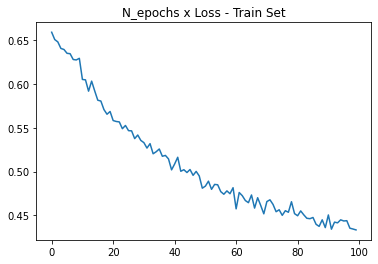

In [ ]:
plt.plot(train_loss_list)
plt.title("N_epochs x Loss - Train Set")

In [ ]:
print("Exemplos por segundo:", 20_000/31.98)

Exemplos por segundo: 625.3908692933084


In [ ]:
start = time()
test_loss, acc = test(dataset_imdb_test,model_fullattention,batch_size)
print("Exemplos por segundo:", 25_000/(time()-start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


17740
Loss: 0.5694 Accuracy: 0.7096
Exemplos por segundo: 1409.4974017257664


In [ ]:
print("Numero de parametros Treinaveis: ",sum(p.numel() for p in model_fullattention.parameters() if p.requires_grad))

Numero de parametros Treinaveis:  632102


#Fim do Notebook